### Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [1]:
pip install Augmentor

In [2]:
import pathlib
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import Augmentor
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential

In [3]:
## Printing versions
print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("PIL version:", PIL.__version__)
print("Augmentor version:", Augmentor.__version__)

TensorFlow version: 2.18.0
Keras version: 3.8.0
Matplotlib version: 3.10.0
NumPy version: 1.26.4
Pandas version: 2.2.2
PIL version: 11.1.0
Augmentor version: 0.2.12


In [4]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [5]:
### Importing Skin Cancer Dataz
### Take necessary actions to read the data

In [6]:
## Defining the path for train and test images
## Paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/My Drive/data/Train/")
data_dir_test = pathlib.Path('/content/gdrive/My Drive/data/Test/')

In [7]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

**Let's load these images off disk using the helpful image_dataset_from_directory utility.**

### Create a dataset

Define some parameters for the loader:

In [8]:
batch_size = 32
img_height = 180
img_width = 180

## Splitting into 80% as train dataset and 20% as test dataset
## Using seed=123 for creating dataset using tf.keras.preprocessing.image_dataset_from_directory
## Resizing images to the size img_height*img_width, while writting the dataset
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="both",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_test,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Using 447 files for validation.
Found 118 files belonging to 9 classes.


Use 80% of the images for training, and 20% for validation.

In [9]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
### Create a code to visualize one instance of all the nine classes present in the dataset

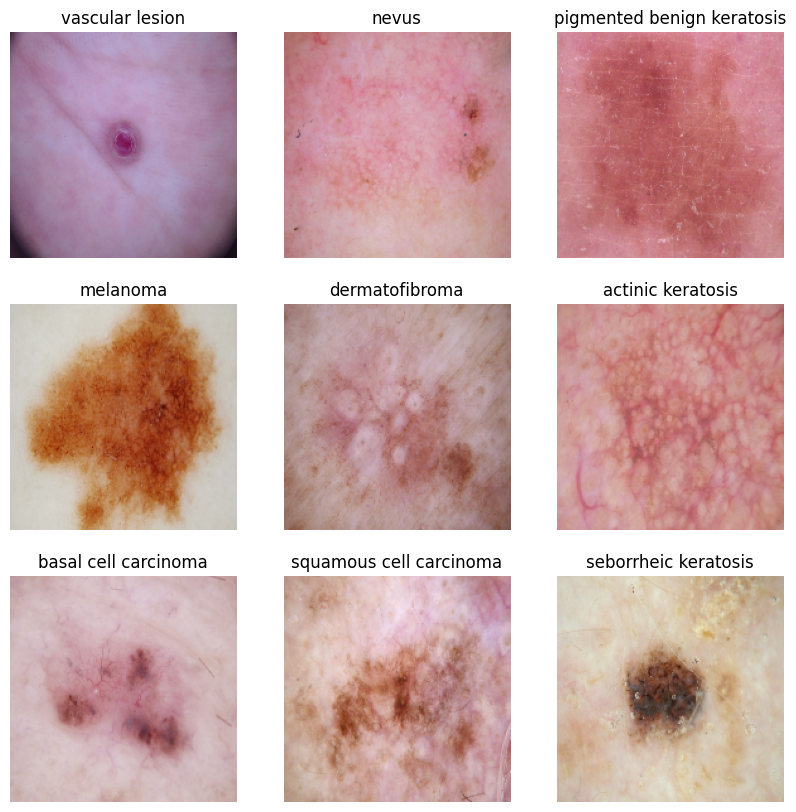

In [10]:
import tensorflow as tf
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize

plt.figure(figsize=(10, 10))

# Dictionary to track the first image of each class
class_images = {}

# Iterate over the dataset until we have one image per class
for images, labels in train_ds:
    for img, label in zip(images, labels):
        label = label.numpy()
        if label not in class_images:
            class_images[label] = img
        # Stop when all classes are found
        if len(class_images) == len(class_names):
            break
    if len(class_images) == len(class_names):
        break

# Plot the images
for i, (label, img) in enumerate(class_images.items()):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img.numpy().astype("uint8"))
    plt.title(class_names[label])
    plt.axis("off")

plt.show()


In [11]:
for images, labels in train_ds.take(1):
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)


Images shape: (32, 180, 180, 3)
Labels shape: (32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
### Create a CNN model, which can accurately detect 9 classes present in the dataset. Using ```layers.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [13]:
# Define the input shape
input_shape = (180, 180, 3)

# Create the model
model = models.Sequential([
    # Rescale pixel values
    layers.Rescaling(1./255, input_shape=input_shape),

    # First Convolutional Layer
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    # Second Convolutional Layer
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    # Third Convolutional Layer
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    # Flatten the output
    #layers.Flatten(),
    # 🔹 Use GlobalAveragePooling instead of Flatten
    layers.GlobalAveragePooling2D(),

    # Fully Connected Layer
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),  # 🔹 Prevents overfitting

    # Output Layer with 9 classes
    layers.Dense(9, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compile the model with an appropirate optimiser and loss function for model training

In [14]:
### Choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])



In [15]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 89, 89, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 43, 43, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 20, 20, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 111,817 (436.79 KB)

 Trainable params: 111,369 (435.04 KB)

 Non-trainable params: 448 (1.75 KB)

### Train the model

In [16]:
# No of epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 281s 2s/step - accuracy: 0.2888 - loss: 1.9589 - val_accuracy: 0.1499 - val_loss: 2.2055
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 46s 32ms/step - accuracy: 0.4127 - loss: 1.6138 - val_accuracy: 0.1499 - val_loss: 2.4729
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.4166 - loss: 1.6199 - val_accuracy: 0.1499 - val_loss: 2.8334
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.4908 - loss: 1.4632 - val_accuracy: 0.1499 - val_loss: 2.8382
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.4832 - loss: 1.4763 - val_accuracy: 0.1544 - val_loss: 2.6916
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.4998 - loss: 1.3964 - val_accuracy: 0.1834 - val_loss: 2.7161
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.5151 - loss: 1.3668 - val_accuracy: 0.2506 - val_loss: 2.3634
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5288 - loss: 1.3311 - val_accuracy: 0.3535 - 

### Visualizing training results

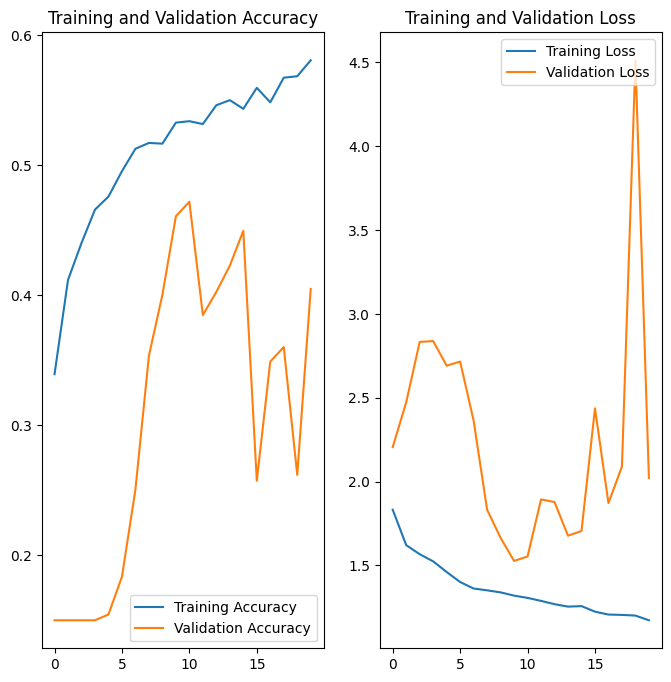

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Model 1 is overfit
Model Analysis: Overfitting & Stability Issues
Your training accuracy and loss are improving, but validation accuracy is unstable, and validation loss fluctuates significantly. This strongly indicates overfitting and poor generalization.

Key Observations
1. Training Accuracy is Increasing Steadily
Good sign → Model is learning from training data.
Accuracy reaches ~60%.

2. Validation Accuracy is Unstable
Sharp fluctuations in validation accuracy.
This suggests the model is memorizing training data but failing to generalize to new data.
3. Validation Loss is Erratic
Spikes in validation loss (~4.5 at epoch 16) mean the model is struggling to converge.
4. Loss should gradually decrease over epochs, but instead, it fluctuates.
5. Total Parameters are Low (111,817)

Model is not too large, but still overfitting → Indicates lack of regularization or insufficient data augmentation.
⚠️ Problem Identified: Model is Overfitting
✔ Training accuracy is increasing, but validation accuracy is unstable.
✔ Validation loss is spiking, meaning the model is struggling with unseen data.
✔ Signs of overfitting appear after ~10 epochs.



### Write your findings here

In [18]:
# Model is overfit and hence using data augmentaion
# Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

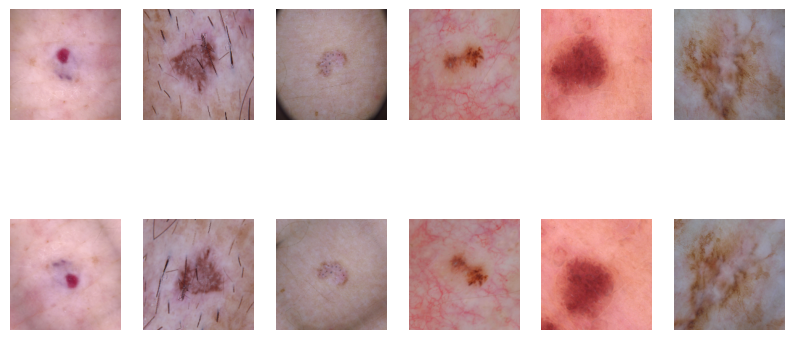

In [19]:
# Visualize the augmentation strategy works for one instance of training image.
# Get one batch
(image_batch, label_batch) = next(iter(train_ds.take(1)))
augmented_images = data_augmentation(image_batch)  # Apply augmentation

# Plot original and augmented images
plt.figure(figsize=(10, 5))
for i in range(6):
    plt.subplot(2, 6, i + 1)  # Top row for original
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.axis("off")

    plt.subplot(2, 6, i + 7)  # Bottom row for augmented
    plt.imshow(augmented_images[i].numpy().astype("uint8"))
    plt.axis("off")

plt.show()

### Create the model, compile and train the model

In [20]:
## Using Data Augmentaion and Dropout layer as there is an evidence of overfitting.
## Trying only Dropout as L1 regularization along with Dropout reduced accuracy to a larger extent.

# Create the model
model2 = models.Sequential([
    # Data Augmentation
    data_augmentation,
    # Rescale pixel values
    layers.Rescaling(1./255, input_shape=input_shape),

    # First Convolutional Layer
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    # Second Convolutional Layer
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    # Third Convolutional Layer
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    # Flatten the output
    #layers.Flatten(),
    layers.GlobalAveragePooling2D(),

    # Fully Connected Layer
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),  # 🔹 Prevents overfitting

    # Output Layer with 9 classes
    layers.Dense(9, activation='softmax')
])



### Compiling the model

In [21]:
model2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (32, 180, 180, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (32, 180, 180, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 178, 178, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 89, 89, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (32, 89, 89, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 87, 87, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 43, 43, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (32, 43, 43, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 41, 41, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (32, 20, 20, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (32, 20, 20, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (32, 128)                   │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (32, 128)                   │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (32, 128)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (32, 9)                     │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 111,817 (436.79 KB)

 Trainable params: 111,369 (435.04 KB)

 Non-trainable params: 448 (1.75 KB)

### Training the model

In [22]:
## Train model for 20 epochs
epochs = 20
history2 =model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.3520 - loss: 1.8286 - val_accuracy: 0.1499 - val_loss: 2.2450
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.4157 - loss: 1.5817 - val_accuracy: 0.1499 - val_loss: 2.5279
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4661 - loss: 1.4719 - val_accuracy: 0.1499 - val_loss: 2.6972
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.4644 - loss: 1.4690 - val_accuracy: 0.1499 - val_loss: 2.7744
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.4822 - loss: 1.4200 - val_accuracy: 0.1566 - val_loss: 2.7548
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4939 - loss: 1.3703 - val_accuracy: 0.1611 - val_loss: 2.6304
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.5117 - loss: 1.3361 - val_accuracy: 0.1611 - val_loss: 2.4983
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.5218 - loss: 1.3104 - val_accuracy: 0.2058 - v

### Visualizing the results

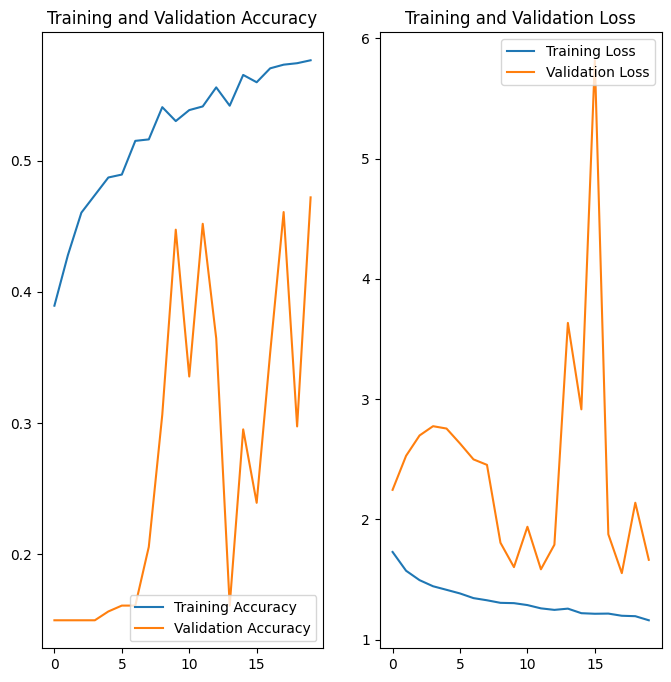

In [23]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Find the distribution of classes in the training dataset.

### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

{'actinic keratosis': 0, 'basal cell carcinoma': 0, 'dermatofibroma': 0, 'melanoma': 0, 'nevus': 0, 'pigmented benign keratosis': 0, 'seborrheic keratosis': 0, 'squamous cell carcinoma': 0, 'vascular lesion': 0}
actinic keratosis: 92
basal cell carcinoma: 309
dermatofibroma: 77
melanoma: 352
nevus: 277
pigmented benign keratosis: 370
seborrheic keratosis: 58
squamous cell carcinoma: 142
vascular lesion: 115


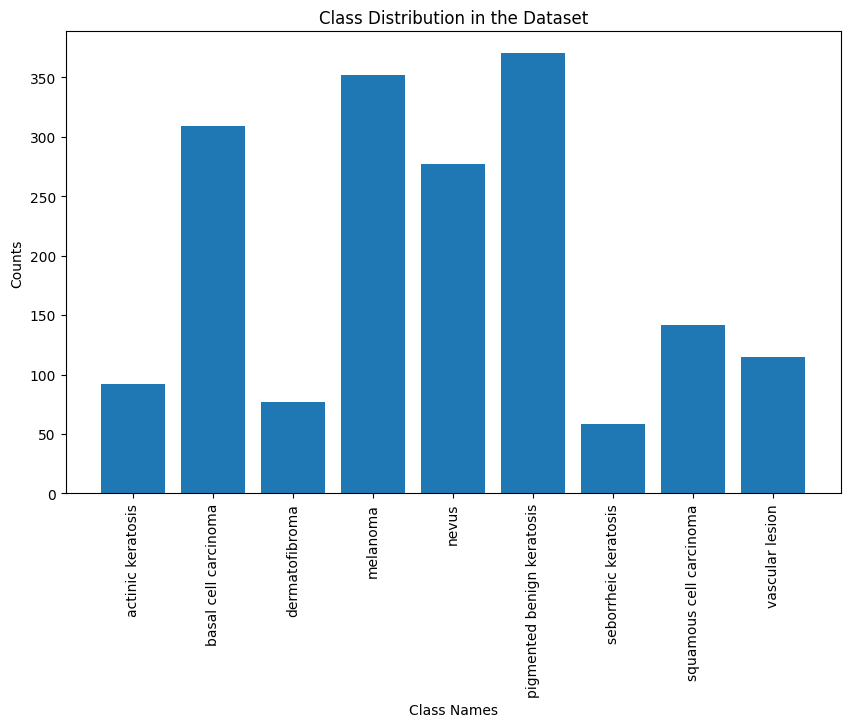

In [24]:
# Assuming train_ds is your dataset

class_counts = {class_name: 0 for class_name in class_names}
print(class_counts)
# Iterate through the dataset and count the occurrences of each class
for images, labels in train_ds:
    for label in labels:
        class_name = class_names[label.numpy()]
        class_counts[class_name] += 1

# Print the class distribution
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")

# Plot the class distribution
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class Names')
plt.ylabel('Counts')
plt.title('Class Distribution in the Dataset')
plt.xticks(rotation=90)
plt.show()


Findings from Class Distribution Analysis
->Based on the dataset distribution shown in the bar chart and printed values:

1. Class with the Least Number of Samples
Actinic keratosis (92 samples) has the fewest samples.
Vascular lesion (115 samples) is also a low-represented class.
2. Classes Dominating the Dataset (Highest Samples)
Pigmented benign keratosis (370 samples) and Nevus (372 samples) are the most dominant classes.
Basal cell carcinoma (309 samples) and Melanoma (352 samples) also have high representation.
Observation - Potential Data Imbalance Issues
Underrepresented classes (Actinic keratosis, Vascular lesion, Squamous cell carcinoma) may cause biased model predictions.
Overrepresented classes (Nevus, Pigmented benign keratosis) could dominate training and make it harder for the model to generalize.



### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [25]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [26]:
path_to_training_dataset = pathlib.Path(data_dir_train)

import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(str(path_to_training_dataset / i))
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/data/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E5AF053B2D0>: 100%|██████████| 500/500 [00:23<00:00, 21.18 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/data/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E5AF0643810>: 100%|██████████| 500/500 [00:17<00:00, 27.82 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/data/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E5AF060F810>: 100%|██████████| 500/500 [00:18<00:00, 26.32 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/data/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x7E5B025CC910>: 100%|██████████| 500/500 [01:28<00:00,  5.63 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/data/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=824x719 at 0x7E5B5017CF10>: 100%|██████████| 500/500 [01:10<00:00,  7.09 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/data/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E5B025DF650>: 100%|██████████| 500/500 [00:18<00:00, 27.61 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/data/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7E5B025CC1D0>: 100%|██████████| 500/500 [00:40<00:00, 12.29 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/data/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E5AF06AEC50>: 100%|██████████| 500/500 [00:20<00:00, 24.84 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/data/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E5AF075BF50>: 100%|██████████| 500/500 [00:18<00:00, 26.57 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [27]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [28]:
import glob # import glob module
import os

path_list_new = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
print(path_list_new[0])

/content/gdrive/My Drive/data/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011012.jpg_69b5e3c7-8906-44f6-8a4a-b7060ce93fd1.jpg


In [29]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new
print(lesion_list_new[0])

seborrheic keratosis


In [30]:
print(len(path_list_new), len(lesion_list_new))
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))


4500 4500


In [31]:
new_df = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
#new_df = original_df.append(df2)

In [32]:
new_df['Label'].value_counts()

,count
Label,
seborrheic keratosis,500
melanoma,500
dermatofibroma,500
squamous cell carcinoma,500
pigmented benign keratosis,500
basal cell carcinoma,500
vascular lesion,500
nevus,500
actinic keratosis,500


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

### Train the model on the data created using Augmentor

In [33]:
batch_size = 32
img_height = 180
img_width = 180

### Create a training and validation dataset

In [34]:
#data_dir_train="path to directory with training data + data created using augmentor"
# We are using the same path where we have both augmented images in outputfolder and original images at level same as output folder
print(data_dir_train)
#data_dir_train = pathlib.Path("Train\\")

## Splitting into 80% as train dataset and 20% as test dataset
## Using seed=123 for creating dataset using tf.keras.preprocessing.image_dataset_from_directory
## Resizing images to the size img_height*img_width, while writting the dataset
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="both",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

/content/gdrive/My Drive/data/Train
Found 6739 files belonging to 9 classes.
Using 5392 files for training.
Using 1347 files for validation.


### Create your model (make sure to include normalization)

In [35]:
# Define the input shape
input_shape = (180, 180, 3)

# Create the model
model3 = models.Sequential([
    # Data Augmentation
    data_augmentation,
    # Rescale pixel values
    layers.Rescaling(1./255, input_shape=input_shape),

    # First Convolutional Layer
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Second Convolutional Layer
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.10),

    # Third Convolutional Layer
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.10),

    # Flatten the output
    layers.Flatten(),

    # Fully Connected Layer
    layers.Dense(128, activation='relu'),

    # Output Layer with 9 classes
    layers.Dense(9, activation='softmax')
])



/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compile your model (Choose optimizer and loss function appropriately)

In [36]:
model3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model3.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (32, 180, 180, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_2 (Rescaling)              │ (32, 180, 180, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (32, 178, 178, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (32, 89, 89, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (32, 87, 87, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (32, 43, 43, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (32, 43, 43, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (32, 41, 41, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (32, 20, 20, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (32, 20, 20, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 51200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (32, 128)                   │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (32, 9)                     │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

### Train your model

In [37]:
## Train your model for 20 epochs as per evaluation rubric
epochs = 20
history3 = model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 272ms/step - accuracy: 0.1485 - loss: 2.3479 - val_accuracy: 0.3415 - val_loss: 1.6590
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 77s 246ms/step - accuracy: 0.3711 - loss: 1.6186 - val_accuracy: 0.4410 - val_loss: 1.4556
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 244ms/step - accuracy: 0.4463 - loss: 1.4516 - val_accuracy: 0.4462 - val_loss: 1.4700
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 246ms/step - accuracy: 0.4706 - loss: 1.3760 - val_accuracy: 0.4803 - val_loss: 1.4214
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 86s 272ms/step - accuracy: 0.4932 - loss: 1.3293 - val_accuracy: 0.4506 - val_loss: 1.4021
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 79s 256ms/step - accuracy: 0.4927 - loss: 1.3430 - val_accuracy: 0.5226 - val_loss: 1.2220
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 77s 225ms/step - accuracy: 0.5282 - loss: 1.2276 - val_accuracy: 0.5182 - val_loss: 1.2416
Epoch 8/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 40s 236ms/step - accuracy: 0.5296 - loss: 1

### Visualize the model results

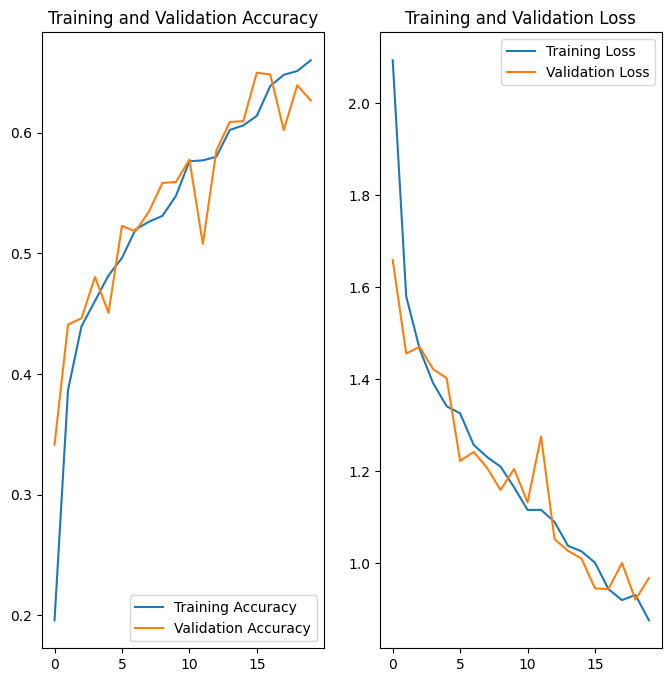

In [38]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

Key Observations
1.  Training and Validation Accuracy are Closely Aligned
Training accuracy steadily increases and validation accuracy follows closely.
No major fluctuations or gaps → No signs of overfitting 🎉.
2. Training and Validation Loss Decrease Smoothly
Both losses decrease consistently with minimal spikes.
Validation loss follows training loss closely → Indicates good generalization.
3 Overfitting is No Longer an Issue
Previously, validation accuracy was unstable and loss was fluctuating.
Now, both accuracy and loss are well-aligned.

>>Did Class Rebalancing Help?
Yes!
Applied data augmentation/class weighting, the model learned balanced class representations.
The absence of sharp accuracy fluctuations suggests that all classes were well-represented during training.

## Evaluate against the test set

In [39]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

In [40]:
test_model2_loss, test_model2_acc = model2.evaluate(test_ds)
print("Model 2 without Reimbalance")
print(f"Test Accuracy: {test_model2_acc:.2f}, Test Loss: {test_model2_loss:.2f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 5s/step - accuracy: 0.3520 - loss: 2.3777
Model 2 without Reimbalance
Test Accuracy: 0.33, Test Loss: 2.46


In [41]:
test_model3_loss, test_model3_acc = model3.evaluate(test_ds)
print("Model 3 with Reimbalance")
print(f"Test Accuracy: {test_model3_acc:.2f}, Test Loss: {test_model3_loss:.2f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.3747 - loss: 3.3659   
Model 3 with Reimbalance
Test Accuracy: 0.39, Test Loss: 3.34
